# Introdução

Esse notebook é uma introdução na construção de Gans utilizando o pytorch. A implementação feita neste notebook é a **DCGAN** e tem como base o tutorial disponibilizado pelo [pytorch](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html?highlight=dcgan).

## GAN



## DCGAN

Uma DCGAN é uma extensão direta do GAN descrito acima, exceto que usa explicitamente camadas convolucionais e convolucionais transpostas no discriminador e no gerador respectivamente. Foi descrita pela primeira vez por Radford et al. no artigo "Unsupervised Representation Learning With Deep Convolutional Generative Adversarial Networks". O discriminador é composto por camadas de convolução com stride, camadas de normalização em lote e ativações LeakyReLU. A entrada é uma imagem de 3x64x64 e a saída é uma probabilidade escalar que indica se a entrada é proveniente da distribuição de dados real. O gerador é composto por camadas de convolução transposta, camadas de normalização em lote e ativações ReLU. A entrada é um vetor latente, zz, que é retirado de uma distribuição normal padrão, e a saída é uma imagem RGB de 3x64x64. As camadas de convolução transposta com stride permitem que o vetor latente seja transformado em um volume com a mesma forma de uma imagem. No artigo, os autores também oferecem algumas dicas sobre como configurar os otimizadores, como calcular as funções de perda e como inicializar os pesos do modelo, tudo isso será explicado nas seções seguintes.

## Conv Transpose

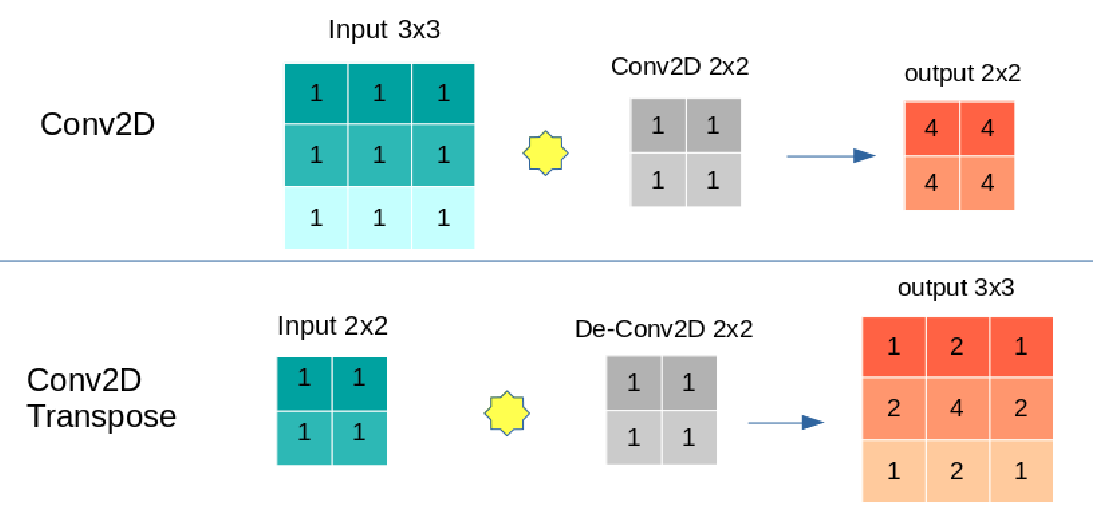

## Importação de bibliotecas

In [1]:
#%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML


manualSeed = 100

torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

## Configuração da DCGAN

- **dataroot** - o caminho para a raiz da pasta do conjunto de dados. Falaremos mais sobre o conjunto de dados na próxima seção.

- **workers** - o número de threads de trabalho para carregar os dados com o DataLoader.

- **batch_size** - o tamanho do lote utilizado no treinamento. O artigo da DCGAN usa um tamanho de lote de 128.

- **image_size** - o tamanho espacial das imagens usadas para treinamento. Esta implementação padrão é 64x64. Se um tamanho diferente for desejado, as estruturas de D e G devem ser alteradas. Veja aqui para mais detalhes.

- **nc** - número de canais de cor nas imagens de entrada. Para imagens coloridas, isso é 3.

- **nz** - comprimento do vetor latente.

- **ngf** - relacionado à profundidade dos mapas de características carregados pelo gerador.

- **ndf** - define a profundidade dos mapas de características propagados pelo discriminador.

- **num_epochs** - número de épocas de treinamento a serem executadas. Treinar por mais tempo provavelmente levará a melhores resultados, mas também levará muito mais tempo.

- **lr** - taxa de aprendizado para o treinamento. Como descrito no artigo da DCGAN, esse número deve ser 0.0002.

- **beta1** - hiperparâmetro beta1 para otimizadores Adam. Como descrito no artigo, esse número deve ser 0.5.

In [5]:
# Diretorio para o dataset
dataroot = "./dataset_celeb"

# Numero de workers para os dataloaders
workers = 2

# Tamanho do batch durante o treinamento
batch_size = 512

# Tamanho das imagens (imagens quadradas) que serão redimensionadas para o tamanho da imagem
image_size = 64

# numero de canais de imagens (imagens coloridas = 3)
nc = 3

# tamanho do vetor latente (z) que será usado como entrada para o gerador
nz = 100

# Tamanho dos feature maps do gerador
ngf = 64

# tamanho dos feature maps do discriminador
ndf = 64

#  Número de épocas de treinamento
num_epochs = 5

# learning rate para otimizadores
lr = 0.0002

#  Beta1 hyperparam para Adam optimizers
beta1 = 0.5

## Dataset

Vamos utilizar neste tutorial o dataset celeb disponível em: http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

ou no kragle https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?resource=download

### Carregando e visualizando algumas imagens do dataset

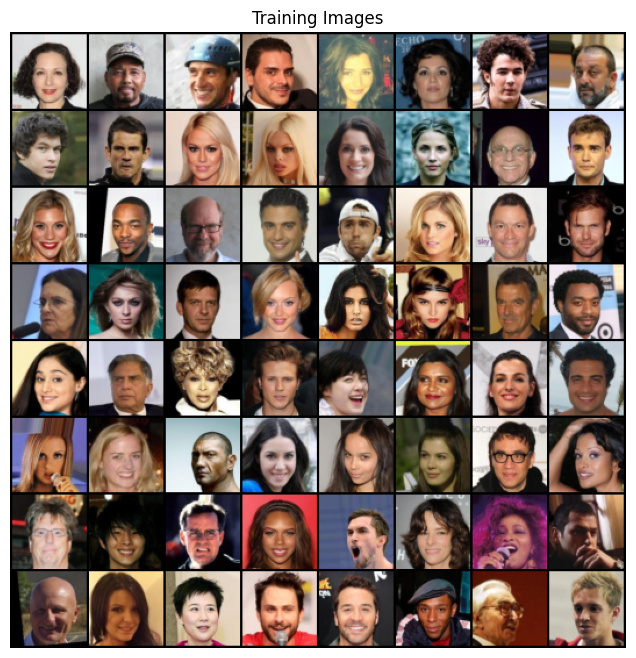

In [6]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
# imagem de 3x64x64 para 64x64x3 (1, 2, 0)
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1,2,0)))
plt.show()

## Inicialização de pesos

No artigo da DCGAN, os autores especificam que todos os pesos do modelo devem ser inicializados aleatoriamente a partir de uma distribuição Normal com **média=0** e **desvio padrão=0.02**. A função `weights_init` recebe um modelo inicializado como entrada e reinicializa todas as camadas de convolução, convolução transposta e normalização em lote para atender a esse critério. Essa função é aplicada aos modelos imediatamente após a inicialização.


In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Gerador

O gerador é desenvolvido para a partir do espaço latente (z) e gerar uma imagem no nosso caso. Dessa forma vamos iniciar o modelo com o input sendo o espaço latent de tamanho (nz) e a resposta do modelo será uma imagem de tamanho (BATCH_SIZExncxngfxngf).

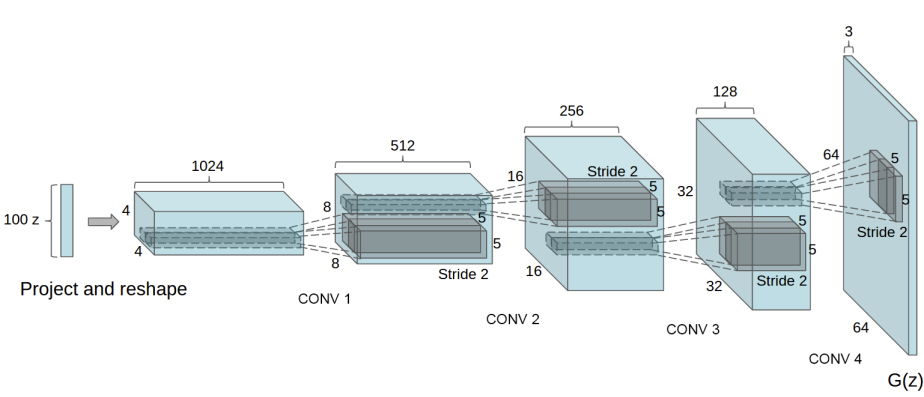



In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution (100, 64)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [17]:
netG = Generator().to(device)


netG.apply(weights_init)

netG

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## Discriminador

Conforme mostrado em aula, o discriminador é responsável por discernir se uma dada imagem é falsa (gerada pelo gerador) ou não (da nossa base de dados). Dessa forma, ele vai receber uma imagem (ou um batch de imagens) e dará uma resposta binária 0, 1 (ou uma resposta para cada imagem no batch)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

Inicialização do discriminador

In [11]:
# Create the Discriminator
netD = Discriminator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Com a configuração de DD e GG, podemos especificar como eles aprendem por meio das funções de perda e otimizadores. Usaremos a função de perda de Entropia Cruzada Binária (BCELoss), que é definida no PyTorch como:

$ℓ(x,y)=L=\{l_1,…,l_N\}^⊤,l_n=−[y_n⋅log⁡x_n+(1−y_n)⋅log⁡(1−x_n)]$

Note como essa função fornece o cálculo de ambos os componentes logarítmicos na função objetivo (ou seja, $log(D(x))$ e $log(1−D(G(z))))$. Podemos especificar qual parte da equação BCE usar com a entrada y. Isso é realizado no loop de treinamento que vem a seguir, mas é importante entender como podemos escolher qual componente queremos calcular apenas mudando y (ou seja, rótulos GT).


In [9]:
criterion = nn.BCELoss()


fixed_noise = torch.randn(64, nz, 1, 1, device=device)

real_label = 1.
fake_label = 0.


optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Treinamento


In [10]:
def train_discriminator(real_cpu, label, model, optimizer):
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    model.zero_grad()
    
    # Forward pass real batch through D
    output = model(real_cpu).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = model(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizer.step()
    return errD, D_x, D_G_z1, fake

def train_generator(netG, netD, optimizer, label, fake):
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizer.step()
    return errG, D_G_z2

In [12]:
## Carregar o modelo
netG.load_state_dict(torch.load('generator.pth', weights_only=True))
netD.load_state_dict(torch.load('discriminator.pth', weights_only=True))

<All keys matched successfully>

In [11]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Treinar o discriminador
        errD, D_x, D_G_z1, fake = train_discriminator(real_cpu, label, netD, optimizerD)
        
        # Treinar o gerador
        errG, D_G_z2 = train_generator(netG, netD, optimizerG, label, fake)

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/396]	Loss_D: 1.7549	Loss_G: 5.3255	D(x): 0.6314	D(G(z)): 0.6358 / 0.0086
[0/5][50/396]	Loss_D: 0.1841	Loss_G: 5.9555	D(x): 0.9192	D(G(z)): 0.0141 / 0.0075
[0/5][100/396]	Loss_D: 0.1814	Loss_G: 5.4017	D(x): 0.9067	D(G(z)): 0.0378 / 0.0146
[0/5][150/396]	Loss_D: 0.5804	Loss_G: 5.7945	D(x): 0.9490	D(G(z)): 0.3592 / 0.0065
[0/5][200/396]	Loss_D: 3.1018	Loss_G: 5.1463	D(x): 0.1311	D(G(z)): 0.0013 / 0.0128
[0/5][250/396]	Loss_D: 0.7790	Loss_G: 3.7674	D(x): 0.7926	D(G(z)): 0.3467 / 0.0394
[0/5][300/396]	Loss_D: 0.6918	Loss_G: 3.0225	D(x): 0.8212	D(G(z)): 0.3387 / 0.0717
[0/5][350/396]	Loss_D: 0.6189	Loss_G: 3.3957	D(x): 0.8419	D(G(z)): 0.3062 / 0.0605
[1/5][0/396]	Loss_D: 0.7214	Loss_G: 4.7469	D(x): 0.8467	D(G(z)): 0.3657 / 0.0203
[1/5][50/396]	Loss_D: 0.8481	Loss_G: 4.7918	D(x): 0.5678	D(G(z)): 0.0167 / 0.0165
[1/5][100/396]	Loss_D: 0.5798	Loss_G: 3.8440	D(x): 0.7513	D(G(z)): 0.1775 / 0.0326
[1/5][150/396]	Loss_D: 0.5781	Loss_G: 3.0868	D(x): 0.7136	D(G(z)): 

## Resultados

NameError: name 'G_losses' is not defined

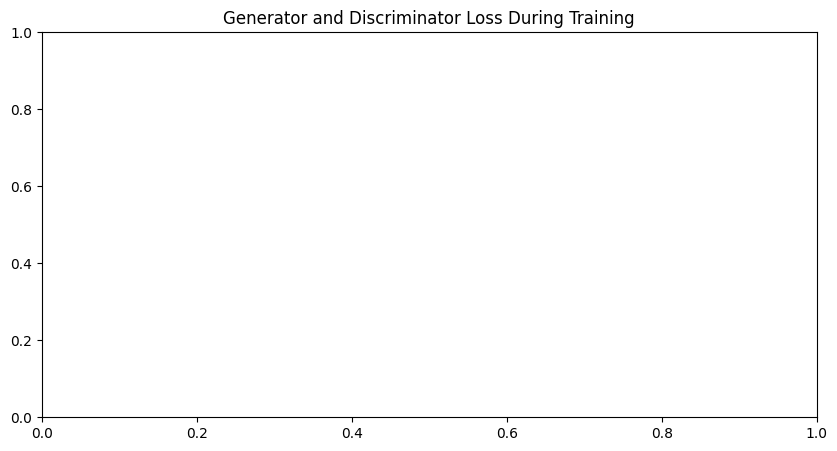

In [13]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

## Novos Resultados

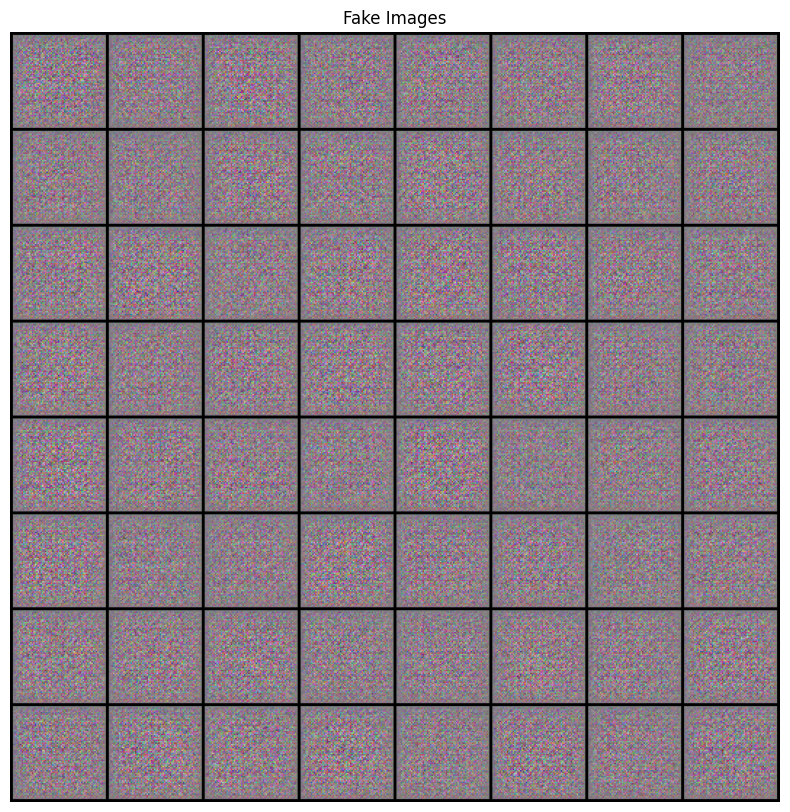

In [18]:
# Realizar a inferência com o gerador
new_noise = torch.randn(64, nz, 1, 1, device=device)
with torch.no_grad():
    fake = netG(new_noise).detach().cpu()

plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
plt.show()

## Salvando o modelo

In [15]:
# Salvar o modelo
torch.save(netG.state_dict(), 'generator.pth')
torch.save(netD.state_dict(), 'discriminator.pth')